In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [3]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, bias=False),
                                      nn.BatchNorm2d(64),
                                      nn.ReLU(inplace=True), 
                                      nn.Dropout(0.3), 
                                      nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False), 
                                      nn.BatchNorm2d(64), 
                                      nn.ReLU(inplace=True), 
                                      nn.MaxPool2d(kernel_size=2, stride=2),

                                      nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(inplace=True),
                                      nn.Dropout(0.4),
                                      nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
                                      nn.BatchNorm2d(128),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),

                                      nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
                                      nn.BatchNorm2d(256),
                                      nn.ReLU(inplace=True),
                                      nn.Dropout(0.4),
                                      nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
                                      nn.BatchNorm2d(256),
                                      nn.ReLU(inplace=True),
                                      nn.Dropout(0.4),
                                      nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
                                      nn.BatchNorm2d(256),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),

                                      nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU(inplace=True),
                                      nn.Dropout(0.4),
                                      nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU(inplace=True),
                                      nn.Dropout(0.4),
                                      nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),

                                      nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU(inplace=True),
                                      nn.Dropout(0.4),
                                      nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU(inplace=True),
                                      nn.Dropout(0.4),
                                      nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
                                      nn.BatchNorm2d(512),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2))

        self.classifier = nn.Sequential(nn.Linear(512, 512, bias=False), 
                                        nn.Dropout(0.5), 
                                        nn.BatchNorm1d(512), 
                                        nn.ReLU(inplace=True), 
                                        nn.Dropout(0.5), 
                                        nn.Linear(512, num_classes))

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [4]:
model = XAI()
model.cpu()
# model.to(device)

# DONE model.eval()
# Sets the module in evaluation mode.
# This is equivalent with self.train(False).
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html
model.eval()

from IPython.display import clear_output 
clear_output()

In [5]:
print(f"is_cuda - model    : {next(model.parameters()).is_cuda}")

is_cuda - model    : False


In [6]:
from torchsummary import summary
summary(model, input_size=(3, 100, 100), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 98, 98]           1,728
       BatchNorm2d-2           [-1, 64, 98, 98]             128
              ReLU-3           [-1, 64, 98, 98]               0
           Dropout-4           [-1, 64, 98, 98]               0
            Conv2d-5           [-1, 64, 98, 98]          36,864
       BatchNorm2d-6           [-1, 64, 98, 98]             128
              ReLU-7           [-1, 64, 98, 98]               0
         MaxPool2d-8           [-1, 64, 49, 49]               0
            Conv2d-9          [-1, 128, 49, 49]          73,728
      BatchNorm2d-10          [-1, 128, 49, 49]             256
             ReLU-11          [-1, 128, 49, 49]               0
          Dropout-12          [-1, 128, 49, 49]               0
           Conv2d-13          [-1, 128, 49, 49]         147,456
      BatchNorm2d-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [7]:
class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        # TODO self.hook ???
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
   
    def hook_fn(self, module, input, output):
        output = output
        #self.features = output.to(device).detach().numpy()
        self.features = output.detach().numpy()
    def remove(self): 
        self.hook.remove()

In [8]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab\ Notebooks/Torch/chap05/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Torch/chap05/data


image shape: torch.Size([1, 3, 100, 100])


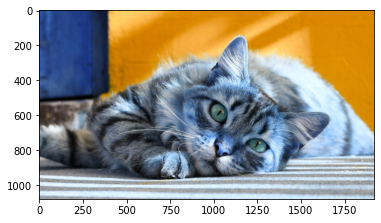

In [9]:
img = cv2.imread("cat.jpg")   
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)

print(f"image shape: {img.shape}")

In [10]:
# from typing import Optional

# def print_module_name(model: nn.Module, num: int):
#     cnt = 0
#     for module in model.named_modules():
#         if cnt == num:
#             return module
#         else:
#             cnt += 1
#     return 0

In [11]:
result = LayerActivations(model.features, 0)
model(img)
activations = result.features

print(f"activations shape: {activations.shape}")

# print_module_name(model, 0)

activations shape: (1, 64, 98, 98)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [13]:
# DONE Keras 예제처럼 출력하기
images_per_row = 16

layer_list = [0, 10, 20]

for i in layer_list:
    result = LayerActivations(model.features, i)
    model(img)
    activations = result.features

    print(f"activations shape: {activations.shape}")

    n_features = activations.shape[1]
    size = activations.shape[-1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                            images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = activations[0, channel_index, :, :].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[col * (size + 1): (col + 1) * size + col,
                        row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))

    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

Output hidden; open in https://colab.research.google.com to view.